In [298]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from copy import deepcopy

import sys
import os
import subprocess
import glob
from collections import defaultdict

In [269]:
directory = "/home/ian/Projects/work/md-lv/simulations/replica_v11_vf5_t1e-4"

In [270]:
%cd $directory

/home/ian/Projects/work/md-lv/simulations/replica_v11_vf5_t1e-4


In [271]:
pwd

'/home/ian/Projects/work/md-lv/simulations/replica_v11_vf5_t1e-4'

In [272]:
def fetch_xyz(file, dim=2, stride=1):
    assert(dim==2 or dim==3)
    output = []
    idx = 0
    with open(file, "r") as xyz:
        try:
            while True:
                N = int(xyz.readline())
                xyz.readline()
                arr = np.empty((N, dim))
                for i in np.arange(N):
                    line = xyz.readline()
                    _, x, y, _ = line.split()
                    if dim == 2:
                        arr[i] = np.array([float(x), float(y)])
                    else:
                        arr[i] = np.array([float(x), float(y), float(z)])
                if idx % stride == 0:
                    output.append(arr)
        except:
            pass
    return np.array(output)

def msd_simple(traj, ref=0):
    shape = traj.shape
    timesteps = shape[0]
    N = shape[1]
    oN = 1/N
    dim = shape[2]

    msd = np.zeros((timesteps-ref))
    for i in np.arange(ref, timesteps):
        msd[i] = np.mean(np.square(np.linalg.norm(traj[i] - traj[ref], axis=-1)))
    return msd

def msd_wrap(traj, V, ref=0):
    L=np.sqrt(V)
    L2 = L/2
    shape = traj.shape
    timesteps = shape[0]
    N = shape[1]
    oN = 1/N
    dim = shape[2]

    wrap = np.zeros((N, dim))

    msd = np.zeros((timesteps-ref-1))
    for i in np.arange(ref+1, timesteps):
        diff = traj[i] - traj[i-1]
        cond1 = diff > L2
        cond2 = diff < -L2
        wrap += cond2.astype(int) - cond1.astype(int)

        msd[i-ref-1] = np.mean(np.square(np.linalg.norm(traj[i] + L*wrap - traj[ref], axis=-1)))
    return msd, wrap

def msd_wrap_drift(traj, V, ref=0):
    L=np.sqrt(V)
    L2 = L/2
    shape = traj.shape
    timesteps = shape[0]
    N = shape[1]
    oN = 1/N
    dim = shape[2]

    wrap = np.zeros((N, dim))

    msd = np.zeros((timesteps-ref))
    
    for i in np.arange(ref+1, timesteps):
        diff = traj[i] - traj[i-1]
        cond1 = diff > L2
        cond2 = diff < -L2
        wrap += cond2.astype(int) - cond1.astype(int)

        move = traj[i] + L*wrap - traj[ref]

        drift = np.mean(move, axis=0)

        msd[i-ref] = np.mean(np.square(np.linalg.norm(move-drift, axis=-1)))
    return msd, wrap

In [273]:
trajs = sorted(glob.glob("traj_*_step1000000_*"))
logs = sorted(glob.glob("log_*_step1000000_*"))

In [274]:
len(trajs), len(logs)

(10000, 10000)

In [275]:
trajs[0], logs[0]

('traj_init_compress_replica_n10_v11_vf5_t0.0001_step1000000_dt0.001_visc5_seed0_out1000.xyz',
 'log_Ib_init_compress_replica_n10_v11_vf5_t0.0001_step1000000_dt0.001_visc5_seed0_out1000.dat')

In [276]:
len(logs)

10000

In [389]:
data = []
for l in logs:
    data.append(np.loadtxt(l))
data = np.array(data)[:,:]

In [390]:
msd_data_drift = []
for j in np.arange(len(trajs)):
    i = j
    if i%1000 == 0:
        print(len(trajs), i)
    f = trajs[i]
    xyz = fetch_xyz(f)
    msd_t, _ = msd_wrap_drift(xyz, 11, ref=0)
    msd_data_drift.append(msd_t)
msd_data_drift = np.array(msd_data_drift)

10000 0
10000 1000
10000 2000
10000 3000
10000 4000
10000 5000
10000 6000
10000 7000
10000 8000
10000 9000


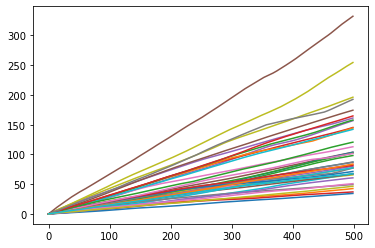

In [326]:
for i in np.arange(0,len(data), 50):
    plt.plot(data[i]-data[i,0])

In [391]:
import mpmath as mp
import scipy as sp
from scipy import special

In [392]:
cp_data = deepcopy(data)

In [394]:
data.shape

(10000, 1000)

In [317]:
cp_factor = deepcopy(cp_data)
for i in np.arange(cp_data.shape[1]):
    cp_factor[:,i] -= cp_data[:,0]

In [318]:
cp_factor

array([[0.00000000e+00, 1.43203563e-01, 2.93948940e-01, ...,
        8.65241255e+01, 8.67099491e+01, 8.68927574e+01],
       [0.00000000e+00, 2.09715298e-01, 4.18450107e-01, ...,
        9.23251132e+01, 9.25038942e+01, 9.26860177e+01],
       [0.00000000e+00, 3.72268349e-01, 7.28251446e-01, ...,
        1.84190104e+02, 1.84544964e+02, 1.84877138e+02],
       ...,
       [0.00000000e+00, 2.58532767e-01, 5.07317598e-01, ...,
        1.11854490e+02, 1.12102757e+02, 1.12337320e+02],
       [0.00000000e+00, 3.78199803e-01, 7.45699680e-01, ...,
        1.70620622e+02, 1.70950667e+02, 1.71283420e+02],
       [0.00000000e+00, 2.67124565e-01, 5.13715553e-01, ...,
        1.17118098e+02, 1.17345763e+02, 1.17578554e+02]])

In [301]:
cp_data[:,0]

array([109.11286744,  71.21829008, 158.61884377, ..., 129.76435356,
       164.20940039, 146.84805763])

In [344]:
data[-5:]

array([[101.13277677, 101.36883843, 101.61012131, ..., 228.32718211,
        228.57922292, 228.82817498],
       [170.3443599 , 170.65214388, 170.95017911, ..., 297.39662039,
        297.66502011, 297.93145257],
       [ 57.30878723,  57.54461907,  57.76651349, ..., 160.66137032,
        160.83125199, 160.99808339],
       [ 65.35217723,  65.47140436,  65.5946468 , ..., 103.49576039,
        103.53946417, 103.59211935],
       [139.30677613, 139.49531886, 139.66164918, ..., 249.67894089,
        249.85934539, 250.03789359]])

In [399]:
def get_bias_quantity(factor, temperature, quantity):
#     cp_factor = deepcopy(factor)
#     for i in np.arange(factor.shape[1]):
#         cp_factor[:,i] -= factor[:,0]
    P = -factor/temperature
    norm = sp.special.logsumexp(P, axis=0)
    numerator = sp.special.logsumexp(P, b=quantity, axis=0)
    return np.exp(numerator-norm)

In [402]:
cut = 10000
bias = get_bias_quantity(data[:cut], 1e-4, msd_data_drift[:cut])

Text(0, 0.5, 'MSD [$\\sigma$]')

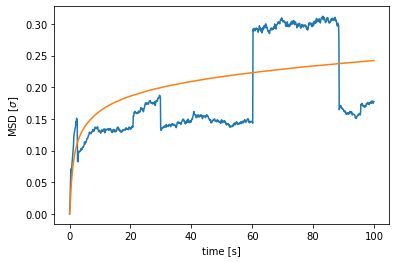

In [403]:
x = np.linspace(0, msd_data_drift[0].shape[-1]/10, msd_data_drift[0].shape[0])
plt.plot(x, bias)
plt.plot(x, np.mean(msd_data_drift, axis=0))
plt.xlabel("time [s]")
plt.ylabel(r"MSD [$\sigma$]")

In [292]:
val_files = sorted(glob.glob("../msd_validation_actual/traj_*t0.0001*_step1000000_*"))

In [293]:
val_files[0]

'../msd_validation_actual/traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6010_out100.xyz'

In [294]:
len(val_files)

200

In [398]:
val_msd_data_drift = defaultdict(list)
for i in np.arange(len(val_files)):
    if i%100 == 0:
        print(len(val_files), i)
    f = val_files[i]
    vol = float(f.split("_")[4][1:])
    xyz = fetch_xyz(f)
    msd_t, _ = msd_wrap_drift(xyz, vol, ref=0)
    val_msd_data_drift[vol].append(msd_t)

200 0
200 100


In [443]:
val_msd_data_drift[5]

[array([0.00000000e+00, 1.06587979e-04, 4.12666547e-04, ...,
        1.32096250e-01, 1.31956497e-01, 1.31976258e-01]),
 array([0.        , 0.00017976, 0.00059717, ..., 0.10519915, 0.10512999,
        0.10475755]),
 array([0.00000000e+00, 9.59994037e-05, 3.48777833e-04, ...,
        1.21475963e-01, 1.21585295e-01, 1.21751454e-01]),
 array([0.00000000e+00, 7.60386242e-05, 2.73072829e-04, ...,
        9.01856779e-02, 9.01229807e-02, 8.96635982e-02]),
 array([0.        , 0.00013138, 0.00049961, ..., 0.11055005, 0.11067307,
        0.11120325]),
 array([0.        , 0.00027943, 0.00096996, ..., 0.11135006, 0.11112311,
        0.11143766]),
 array([0.00000000e+00, 1.44310830e-04, 5.34367113e-04, ...,
        1.48799206e-01, 1.48836734e-01, 1.48397331e-01]),
 array([0.        , 0.00020515, 0.00071549, ..., 0.10169822, 0.10234711,
        0.1019597 ]),
 array([0.00000000e+00, 9.28346392e-05, 3.04051258e-04, ...,
        1.42924741e-01, 1.42871477e-01, 1.42989543e-01]),
 array([0.        , 0.000

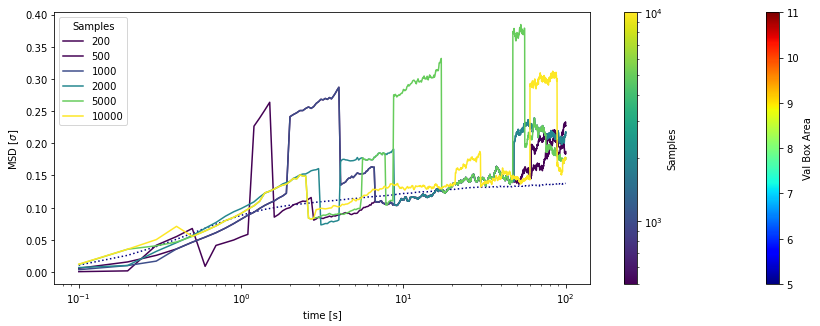

In [446]:
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=5, vmax=11)
cmap2 = mpl.cm.viridis
norm2 = mpl.colors.LogNorm(vmin=500, vmax=10000)
max_t = 10000
plt.figure(figsize=(15,5))
for label, dat in val_msd_data_drift.items():
    if label == 11:
        continue
    plt.plot(np.linspace(0, dat[0].shape[-1]/100, dat[0].shape[-1])[10:max_t:10], np.mean(dat[:200], axis=0)[10:max_t:10], ":", color=cmap(norm(label)), alpha=1)
    x2 = np.linspace(0, dat[0].shape[-1]/100, dat[0].shape[-1])[10:max_t:10]
    y2 = np.mean(dat[:200], axis=0)[10:max_t:10]
    #break
x = np.linspace(0, msd_data_drift[0].shape[-1]/10, msd_data_drift[0].shape[0])
#plt.plot(x[1:], np.mean(msd_data_drift, axis=0)[1:], ":", color=cmap(norm(11)))

for cut in [200, 500, 1000, 2000, 5000, 10000]:
    bias = get_bias_quantity(data[:cut], 1e-4, msd_data_drift[:cut])
    plt.plot(x[1:], bias[1:], color=cmap2(norm2(cut)), label=cut)
plt.xlabel("time [s]")
plt.ylabel(r"MSD [$\sigma$]")
plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), label="Val Box Area")
plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap2, norm=norm2), label="Samples")
#plt.savefig("MSD.png")
#plt.title(f"N={len(trajs)}")
plt.legend(title="Samples")
#plt.yscale('log')
plt.xscale('log')

Text(0, 0.5, 'bias factor')

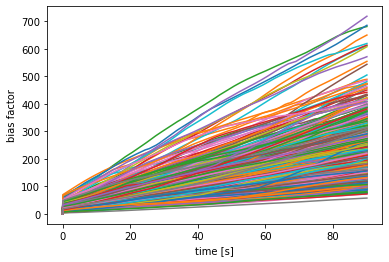

In [267]:
for i in np.arange(0,len(data), 5):
    plt.plot(x, data[i])

plt.xlabel("time [s]")
plt.ylabel("bias factor")

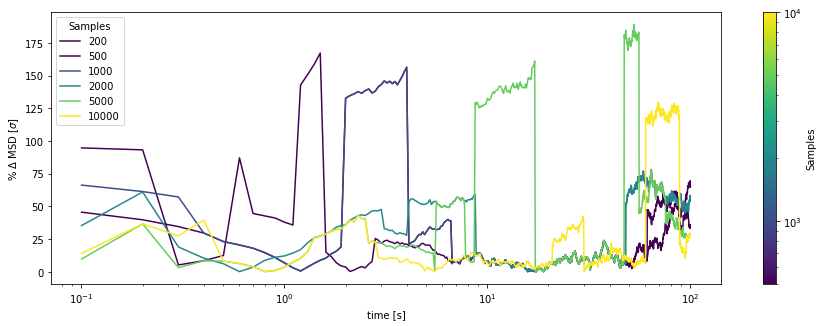

In [464]:
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=5, vmax=11)
cmap2 = mpl.cm.viridis
norm2 = mpl.colors.LogNorm(vmin=500, vmax=10000)
max_t = 10000
plt.figure(figsize=(15,5))
for label, dat in val_msd_data_drift.items():
    if label == 11:
        continue
    #plt.plot(np.linspace(0, dat[0].shape[-1]/100, dat[0].shape[-1])[10:max_t:10], np.mean(dat[:200], axis=0)[10:max_t:10], ":", color=cmap(norm(label)), alpha=1)
    x2 = np.linspace(0, dat[0].shape[-1]/100, dat[0].shape[-1])[10:max_t:10]
    y2 = np.mean(dat[:200], axis=0)[10:max_t:10]
    #break
x = np.linspace(0, msd_data_drift[0].shape[-1]/10, msd_data_drift[0].shape[0])
#plt.plot(x[1:], np.mean(msd_data_drift, axis=0)[1:], ":", color=cmap(norm(11)))

for cut in [200, 500, 1000, 2000, 5000, 10000]:
    bias = get_bias_quantity(data[:cut], 1e-4, msd_data_drift[:cut])
    plt.plot(x[1:], 100*np.abs(bias[1:]-y2)/y2, color=cmap2(norm2(cut)), label=cut)
plt.xlabel("time [s]")
plt.ylabel(r"% $\Delta$ MSD [$\sigma$]")
#plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), label="Val Box Area")
plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap2, norm=norm2), label="Samples")
#plt.savefig("MSD.png")
#plt.title(f"N={len(trajs)}")
plt.legend(title="Samples")
#plt.yscale('log')
plt.xscale('log')

In [465]:
def get_log_norm_numerator(factor, temperature, quantity):
    cp_factor = deepcopy(factor)
    for i in np.arange(factor.shape[1]):
        cp_factor[:,i] -= factor[:,0]
    P = -factor/temperature
    norm = sp.special.logsumexp(P, axis=0)
    numerator = sp.special.logsumexp(P, b=quantity, axis=0)
    return norm, numeratorlse 

In [545]:
cut = 10000
norm, numerator = get_log_norm_numerator(data[:cut], 1, msd_data_drift[:cut])

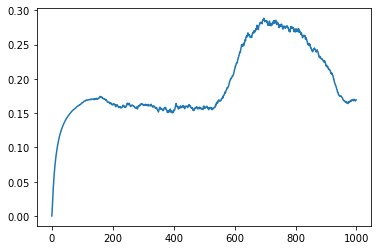

In [546]:
plt.plot(np.exp(numerator-norm))

In [475]:
from mpmath import mp

In [694]:
mp.dps = 100

In [695]:
mp.prec

336

In [692]:
mp.prec = 300

In [684]:
def logsumexp_mp(array):
    maxs = np.max(array, axis=0)
    out = np.zeros_like(maxs)
    for i in np.arange(array.shape[1]):
        summ = mp.mpf(0.0)
        for j in np.arange(array.shape[0]):
            summ += mp.exp(array[j,i]-maxs[i])
        out[i] = float(mp.log(summ)) + maxs[i]
    return out

def logsumexp_weight_mp(array, weight):
    maxs = np.max(array, axis=0)
    out = np.zeros_like(maxs)
    for i in np.arange(array.shape[1]):
        summ = mp.mpf(0.0)
        for j in np.arange(array.shape[0]):
            summ += weight[j,i]*mp.exp(array[j,i]-maxs[i])
        out[i] = float(mp.log(summ)) + maxs[i]
    return out

In [602]:
def get_underflow(array):
    out = np.zeros_like(array)
    maxs = np.max(array, axis=0)
    print(array.shape, out.shape, maxs.shape)
    for i in np.arange(array.shape[1]):
        out[:,i] = np.exp(array[:,i]-maxs[i])
    return np.count_nonzero(out==0, axis=0)/array.shape[0]

In [649]:
def get_bias_quantity_mp(factor, temperature, quantity):
    P = np.array(-factor/temperature, dtype=np.float64)
    print(P.shape)
    print(quantity.shape)
    norm = logsumexp_mp(P)
    numerator = logsumexp_weight_mp(P, quantity)
    return np.exp(numerator-norm)

In [652]:
def get_bias_underflow(factor, temperature, quantity):
    P = np.array(-factor/temperature, dtype=np.float64)
    norm_zero = get_underflow(P)
    return norm_zero

In [653]:
cut = 10000
eff = get_bias_underflow(data[:cut,::1], 1e-4, msd_data_drift[:cut,::1])

(10000, 1000) (10000, 1000) (1000,)


In [696]:
cut = 10000
bias2 = get_bias_quantity_mp(data[:cut,::100], 1e-4, msd_data_drift[:cut,::100])

(10000, 10)
(10000, 10)


In [697]:
bias2

array([0.        , 0.13028674, 0.13382646, 0.13184955, 0.14735173,
       0.14778642, 0.14460422, 0.30332775, 0.29696288, 0.16241555])

In [698]:
bias2

array([0.        , 0.13028674, 0.13382646, 0.13184955, 0.14735173,
       0.14778642, 0.14460422, 0.30332775, 0.29696288, 0.16241555])

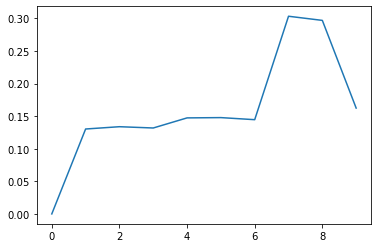

In [699]:
#plt.plot(bias)
plt.plot(bias2)
#plt.yscale('log')
#plt.xscale('log')

Text(0.5, 0, 'Time')

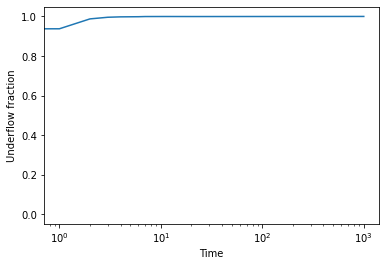

In [633]:
plt.plot(eff)
plt.xscale('log')
plt.ylabel('Underflow fraction')
plt.xlabel('Time')

In [646]:
arr = np.array([mp.mpf(0) for i in range(10)], dtype=object)

In [647]:
arr

array([mpf('0.0'), mpf('0.0'), mpf('0.0'), mpf('0.0'), mpf('0.0'),
       mpf('0.0'), mpf('0.0'), mpf('0.0'), mpf('0.0'), mpf('0.0')],
      dtype=object)

In [642]:
arr[0]

5

Text(0.5, 0, 'Time')

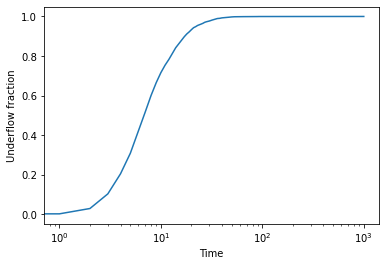

In [607]:
plt.plot(eff)
plt.xscale('log')
plt.ylabel('Underflow fraction')
plt.xlabel('Time')

In [714]:
amin = np.min(data, axis=0)
a2min = np.array([np.min(data[:,i][data[:,i] != amin[i]]) for i in np.arange(data.shape[1])])

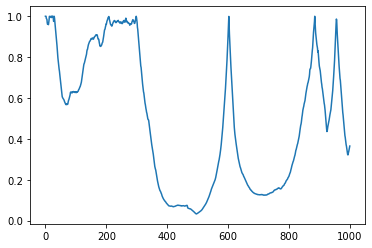

In [718]:
plt.plot(np.exp(amin)/np.exp(a2min))